In [1]:
#imports
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy import stats
import math

from mplsoccer import PyPizza, add_image, FontManager
import matplotlib.pyplot as plt
#soccer plots radar plot
from soccerplots.radar_chart import Radar

from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
df1 = pd.read_excel("LP_Player_DA_Stats.xlsx")
df2 = pd.read_excel("LP_Player_Passing_Stats.xlsx")
df3 = pd.read_excel("LP_Player_SGA_Stats.xlsx")
df4 = pd.read_excel("LP_Player_Aerial_Stats.xlsx")
df5 = pd.read_excel("LP_Player_Pos_Stats.xlsx")

In [3]:
#drop overlapping columns
df2.drop(columns=['Nation','Pos','Age','Born','90s'], inplace=True)
df3.drop(columns=['Pos','Age','Born','90s'], inplace=True)
df5.drop(columns=['Pos','Age','Born','90s','Rk'], inplace=True)

In [4]:
df = pd.merge(df1, df2, on=['Player','Squad'], how='left')
df = pd.merge(df, df3, on=['Player','Squad'], how='left')
df = pd.merge(df, df4, on=['Player','Squad'], how='left')
df = pd.merge(df, df5, on=['Player','Squad'], how='left')

In [5]:
print(df.columns)
print(df.shape)

Index(['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s', 'Tkl', 'TklW',
       'Tkl Def 3rd', 'Tkl Mid 3rd', 'Tkl Att 3rd', 'Tkl vs Dribbles', 'Att',
       'Tkl%', 'Dribbled Past', 'Blocks', 'Blocked Shots', 'Blocked Pass',
       'Int', 'Tkl+Int', 'Clr', 'Err', 'Total Cmp', 'Total Att', 'Total Cmp%',
       'TotDist', 'PrgDist', 'Short Cmp', 'Short Att', 'Short Cmp%',
       'Medium Cmp', 'Medium Att', 'Medium Cmp%', 'Long Cmp', 'Long Att',
       'Long Cmp%', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP',
       'Passes into final third', 'PPA', 'CrsPA', 'Prog', 'SCA', 'SCA90',
       'SCA PassLive', 'SCA PassDead', 'SCA Drib', 'SCA Sh', 'SCA Fld',
       'SCA Def', 'GCA', 'GCA90', 'GCA PassLive', 'GCA PassDead', 'GCA Drib',
       'GCA Sh', 'GCA Fld', 'GCA Def', 'Recov', 'Aerial Won', 'Aerial Lost',
       'Aerial Won%', 'Touches', 'Def Pen', 'Touches Def 3rd',
       'Touches Mid 3rd', 'Touches Att 3rd', 'Touches Att Pen',
       'Dribbles Succ', 'Dribbles Att', 'Dribbles Succ%', 'Dri

In [6]:
#players that played at least 270 min and are defenders
df = df.loc[(df['Pos']=='DF') & (df['90s']>=3)]

In [7]:
df.head()

Player Nation Pos     Squad     Age  Born   90s   Tkl  TklW  \
0   Rodrigo Abascal    URU  DF  Boavista  28-359  1994   7.5  1.87  1.33   
17     Pedro Álvaro    POR  DF   Estoril  22-312  2000  10.9  0.64  0.37   
19     Pedro Amaral    POR  DF   Rio Ave  25-136  1997  11.0  1.55  0.82   
20      André Amaro    COL  DF   Vitória  20-130  2002  13.2  1.67  0.98   
24      Léo Andrade    BRA  DF  Marítimo  24-265  1998  11.8  1.19  0.68   

    Tkl Def 3rd  ...  Touches Mid 3rd  Touches Att 3rd  Touches Att Pen  \
0          1.47  ...             33.3             5.20             0.80   
17         0.37  ...             22.8             1.19             0.28   
19         1.09  ...             30.9            18.90             0.64   
20         1.36  ...             26.9             1.97             0.91   
24         1.02  ...             21.2             2.37             0.93   

    Dribbles Succ  Dribbles Att  Dribbles Succ%  Dribbles Mis  Dribbles Dis  \
0            0.13          0.27            50.0          0.67          0.13   
17           0.37          0.55            66.7          0.09          0.28   
19           0.64          1.82            35.0          0.64          0.64   
20           0.30          0.53            57.1          0.23          0.30   
24           0.08          0.25            33.3          0.59          0.08   

     Rec  Prog Passed Received  
0   45.3                  0.67  
17  43.1                  0.00  
19  43.2                  2.27  
20  33.5                  0.00  
24  29.1                  0.25  

[5 rows x 79 columns]

In [8]:
df_df = df.drop(['Nation','Born'],axis=1).reset_index()

In [9]:
df_df = df_df.drop(['index'],axis=1)

In [10]:
df_df

Player Pos     Squad     Age   90s   Tkl  TklW  Tkl Def 3rd  \
0    Rodrigo Abascal  DF  Boavista  28-359   7.5  1.87  1.33         1.47   
1       Pedro Álvaro  DF   Estoril  22-312  10.9  0.64  0.37         0.37   
2       Pedro Amaral  DF   Rio Ave  25-136  11.0  1.55  0.82         1.09   
3        André Amaro  DF   Vitória  20-130  13.2  1.67  0.98         1.36   
4        Léo Andrade  DF  Marítimo  24-265  11.8  1.19  0.68         1.02   
..               ...  ..       ...     ...   ...   ...   ...          ...   
99    Bernardo Vital  DF   Estoril  22-010  11.0  1.00  0.45         0.82   
100   Steven Vitória  DF    Chaves  35-362  13.0  0.85  0.54         0.69   
101          Wendell  DF     Porto  29-172   7.0  2.43  1.14         1.14   
102     Bruno Wilson  DF    Vizela  26-012  10.4  0.87  0.48         0.38   
103   Nermin Zolotić  DF  Casa Pia  29-185   8.9  1.69  1.24         0.90   

     Tkl Mid 3rd  Tkl Att 3rd  ...  Touches Mid 3rd  Touches Att 3rd  \
0           0.40         0.00  ...             33.3             5.20   
1           0.18         0.09  ...             22.8             1.19   
2           0.45         0.00  ...             30.9            18.90   
3           0.30         0.00  ...             26.9             1.97   
4           0.08         0.08  ...             21.2             2.37   
..           ...          ...  ...              ...              ...   
99          0.18         0.00  ...             18.4             0.45   
100         0.15         0.00  ...             21.5             1.46   
101         1.14         0.14  ...             31.3            14.70   
102         0.48         0.00  ...             17.6             1.54   
103         0.79         0.00  ...             31.6             3.93   

     Touches Att Pen  Dribbles Succ  Dribbles Att  Dribbles Succ%  \
0               0.80           0.13          0.27            50.0   
1               0.28           0.37          0.55            66.7   
2               0.64           0.64          1.82            35.0   
3               0.91           0.30          0.53            57.1   
4               0.93           0.08          0.25            33.3   
..               ...            ...           ...             ...   
99              0.18           0.09          0.09           100.0   
100             1.08           0.08          0.15            50.0   
101             1.29           0.57          1.00            57.1   
102             1.15           0.10          0.10           100.0   
103             0.67           0.22          0.22           100.0   

     Dribbles Mis  Dribbles Dis   Rec  Prog Passed Received  
0            0.67          0.13  45.3                  0.67  
1            0.09          0.28  43.1                  0.00  
2            0.64          0.64  43.2                  2.27  
3            0.23          0.30  33.5                  0.00  
4            0.59          0.08  29.1                  0.25  
..            ...           ...   ...                   ...  
99           0.45          0.27  43.2                  0.09  
100          0.15          0.08  38.5                  0.00  
101          1.14          0.00  37.4                  1.43  
102          0.00          0.00  26.2                  0.00  
103          0.56          0.11  42.1                  0.11  

[104 rows x 77 columns]

In [11]:
df_df.columns

Index(['Player', 'Pos', 'Squad', 'Age', '90s', 'Tkl', 'TklW', 'Tkl Def 3rd',
       'Tkl Mid 3rd', 'Tkl Att 3rd', 'Tkl vs Dribbles', 'Att', 'Tkl%',
       'Dribbled Past', 'Blocks', 'Blocked Shots', 'Blocked Pass', 'Int',
       'Tkl+Int', 'Clr', 'Err', 'Total Cmp', 'Total Att', 'Total Cmp%',
       'TotDist', 'PrgDist', 'Short Cmp', 'Short Att', 'Short Cmp%',
       'Medium Cmp', 'Medium Att', 'Medium Cmp%', 'Long Cmp', 'Long Att',
       'Long Cmp%', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP',
       'Passes into final third', 'PPA', 'CrsPA', 'Prog', 'SCA', 'SCA90',
       'SCA PassLive', 'SCA PassDead', 'SCA Drib', 'SCA Sh', 'SCA Fld',
       'SCA Def', 'GCA', 'GCA90', 'GCA PassLive', 'GCA PassDead', 'GCA Drib',
       'GCA Sh', 'GCA Fld', 'GCA Def', 'Recov', 'Aerial Won', 'Aerial Lost',
       'Aerial Won%', 'Touches', 'Def Pen', 'Touches Def 3rd',
       'Touches Mid 3rd', 'Touches Att 3rd', 'Touches Att Pen',
       'Dribbles Succ', 'Dribbles Att', 'Dribbles Succ%', 'Dribbles Mis',
      

# Variables to analyze centerbacks
- According to Soccerment:
    - Blocks, Clearances, Tackles, Launches, Crosses, SCA, Aerials, Interceptions, Long Pass accuracy, Pass acc own.half, Pass acc. opp. half, Duel Success ratio
    
- According to Athletic: Stats per 1000 opponents touches (event data)
    - Passing % , Long pass, progressive passes

In [12]:
print(df.columns)

Index(['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s', 'Tkl', 'TklW',
       'Tkl Def 3rd', 'Tkl Mid 3rd', 'Tkl Att 3rd', 'Tkl vs Dribbles', 'Att',
       'Tkl%', 'Dribbled Past', 'Blocks', 'Blocked Shots', 'Blocked Pass',
       'Int', 'Tkl+Int', 'Clr', 'Err', 'Total Cmp', 'Total Att', 'Total Cmp%',
       'TotDist', 'PrgDist', 'Short Cmp', 'Short Att', 'Short Cmp%',
       'Medium Cmp', 'Medium Att', 'Medium Cmp%', 'Long Cmp', 'Long Att',
       'Long Cmp%', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP',
       'Passes into final third', 'PPA', 'CrsPA', 'Prog', 'SCA', 'SCA90',
       'SCA PassLive', 'SCA PassDead', 'SCA Drib', 'SCA Sh', 'SCA Fld',
       'SCA Def', 'GCA', 'GCA90', 'GCA PassLive', 'GCA PassDead', 'GCA Drib',
       'GCA Sh', 'GCA Fld', 'GCA Def', 'Recov', 'Aerial Won', 'Aerial Lost',
       'Aerial Won%', 'Touches', 'Def Pen', 'Touches Def 3rd',
       'Touches Mid 3rd', 'Touches Att 3rd', 'Touches Att Pen',
       'Dribbles Succ', 'Dribbles Att', 'Dribbles Succ%', 'Dri

In [13]:
# Which ones to remove: 



In [14]:
df_df = df_df.drop(['Tkl Def 3rd', 'Tkl Mid 3rd', 'Tkl Att 3rd', 'Tkl vs Dribbles','Tkl','Att','Blocked Shots', 'Blocked Pass','Dribbled Past', 'Total Att','TotDist',
'PrgDist', 'Short Att', 'Short Cmp%', 'Medium Cmp', 'Medium Att', 'Medium Cmp%','Long Att','Ast', 'xAG', 'xA', 'A-xAG', 'KP','PPA', 
'CrsPA','SCA90','SCA PassLive', 'SCA PassDead', 'SCA Drib', 'SCA Sh', 'SCA Fld',
       'SCA Def', 'GCA', 'GCA90', 'GCA PassLive', 'GCA PassDead', 'GCA Drib',
       'GCA Sh', 'GCA Fld', 'GCA Def','Aerial Lost','Touches', 'Def Pen','Touches Att 3rd', 'Touches Att Pen',
       'Dribbles Succ', 'Dribbles Att', 'Dribbles Succ%', 'Dribbles Mis',
       'Dribbles Dis','Prog Passed Received'],axis=1)

In [15]:
df_df.shape

(104, 26)

In [16]:
#Check variable stats
df_df.describe()

90s        TklW        Tkl%      Blocks         Int     Tkl+Int  \
count  104.000000  104.000000  104.000000  104.000000  104.000000  104.000000   
mean     8.328846    0.921827   62.620192    1.314423    1.405096    3.186442   
std      3.833999    0.596642   15.340880    0.571525    0.519699    1.073127   
min      3.000000    0.230000   20.000000    0.130000    0.000000    0.750000   
25%      4.975000    0.417500   54.200000    0.860000    1.107500    2.325000   
50%      8.200000    0.820000   61.650000    1.195000    1.440000    3.140000   
75%     11.800000    1.242500   71.400000    1.675000    1.670000    4.140000   
max     14.900000    2.990000  100.000000    2.330000    3.800000    6.600000   

              Clr         Err  Total Cmp  Total Cmp%  ...  Long Cmp%  \
count  104.000000  104.000000  96.000000   96.000000  ...  96.000000   
mean     4.057019    0.019519  45.771875   80.484375  ...  55.370833   
std      2.019718    0.044925  13.933932    6.912526  ...  12.209866   
min      0.580000    0.000000  18.200000   63.800000  ...  23.100000   
25%      2.652500    0.000000  36.275000   76.225000  ...  45.850000   
50%      3.690000    0.000000  43.000000   81.800000  ...  57.000000   
75%      5.030000    0.000000  52.350000   84.975000  ...  65.075000   
max      8.000000    0.230000  97.700000   92.900000  ...  82.700000   

       Passes into final third       Prog        SCA      Recov  Aerial Won  \
count                96.000000  96.000000  96.000000  96.000000   96.000000   
mean                  3.227500   2.804375   1.373854   5.366146    1.963542   
std                   1.835624   1.268344   1.017265   1.405043    1.052475   
min                   0.720000   0.710000   0.000000   2.630000    0.180000   
25%                   1.990000   1.752500   0.577500   4.545000    1.310000   
50%                   2.810000   2.665000   1.000000   5.320000    1.810000   
75%                   4.087500   4.000000   1.962500   6.027500    2.342500   
max                  11.200000   5.240000   4.110000   9.670000    4.330000   

       Aerial Won%  Touches Def 3rd  Touches Mid 3rd        Rec  
count    96.000000        96.000000        96.000000  96.000000  
mean     58.617708        29.927083        29.692708  40.983333  
std      13.107282         9.537974         9.694483  13.000928  
min      16.700000        12.500000        11.900000  16.800000  
25%      50.000000        21.000000        23.100000  31.800000  
50%      61.050000        30.500000        27.450000  39.300000  
75%      66.700000        36.475000        34.200000  49.225000  
max      83.300000        48.300000        60.700000  90.700000  

[8 rows x 22 columns]

In [17]:
#check variable types
df_df.dtypes

Player                      object
Pos                         object
Squad                       object
Age                         object
90s                        float64
TklW                       float64
Tkl%                       float64
Blocks                     float64
Int                        float64
Tkl+Int                    float64
Clr                        float64
Err                        float64
Total Cmp                  float64
Total Cmp%                 float64
Short Cmp                  float64
Long Cmp                   float64
Long Cmp%                  float64
Passes into final third    float64
Prog                       float64
SCA                        float64
Recov                      float64
Aerial Won                 float64
Aerial Won%                float64
Touches Def 3rd            float64
Touches Mid 3rd            float64
Rec                        float64
dtype: object

In [18]:
#Duplicates
duplicates = df_df['Player'].duplicated()
num_duplicates = duplicates.sum()
print(num_duplicates)

15


In [19]:
duplicated_rows = df_df[df_df['Player'].duplicated()]
duplicated_rows

Player Pos           Squad     Age  90s  TklW  Tkl%  Blocks   Int  \
7   Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
8   Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
9   Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
10  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
11  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
12  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
13  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
14  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
15  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
16  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
17  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
18  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
19  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
20  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   
21  Tomás Araújo  DF  Gil Vicente FC  20-237  3.0  0.33  60.0    2.33  1.67   

    Tkl+Int  ...  Long Cmp%  Passes into final third  Prog   SCA  Recov  \
7      4.33  ...       57.7                     5.67  4.33  1.67   7.33   
8      4.33  ...       57.7                     5.67  4.33  1.67    NaN   
9      4.33  ...       57.7                     5.67  4.33  1.67    NaN   
10     4.33  ...       57.7                     5.67  4.33   NaN   7.33   
11     4.33  ...       57.7                     5.67  4.33   NaN   7.33   
12     4.33  ...       57.7                     5.67  4.33   NaN    NaN   
13     4.33  ...       57.7                     5.67  4.33   NaN    NaN   
14     4.33  ...        NaN                      NaN   NaN  1.67   7.33   
15     4.33  ...        NaN                      NaN   NaN  1.67   7.33   
16     4.33  ...        NaN                      NaN   NaN  1.67    NaN   
17     4.33  ...        NaN                      NaN   NaN  1.67    NaN   
18     4.33  ...        NaN                      NaN   NaN   NaN   7.33   
19     4.33  ...        NaN                      NaN   NaN   NaN   7.33   
20     4.33  ...        NaN                      NaN   NaN   NaN    NaN   
21     4.33  ...        NaN                      NaN   NaN   NaN    NaN   

    Aerial Won  Aerial Won%  Touches Def 3rd  Touches Mid 3rd   Rec  
7         4.33         61.9              NaN              NaN   NaN  
8          NaN          NaN             48.3             44.3  57.0  
9          NaN          NaN              NaN              NaN   NaN  
10        4.33         61.9             48.3             44.3  57.0  
11        4.33         61.9              NaN              NaN   NaN  
12         NaN          NaN             48.3             44.3  57.0  
13         NaN          NaN              NaN              NaN   NaN  
14        4.33         61.9             48.3             44.3  57.0  
15        4.33         61.9              NaN              NaN   NaN  
16         NaN          NaN             48.3             44.3  57.0  
17         NaN          NaN              NaN              NaN   NaN  
18        4.33         61.9             48.3             44.3  57.0  
19        4.33         61.9              NaN              NaN   NaN  
20         NaN          NaN             48.3             44.3  57.0  
21         NaN          NaN              NaN              NaN   NaN  

[15 rows x 26 columns]

In [20]:
df_df = df_df.drop_duplicates(subset=['Player'])

In [21]:
nan_count = df_df.isna().sum().sum()

# Print the number of NaN values
print("Number of NaN values:", nan_count)

Number of NaN values: 0


In [22]:
# Count the number of NaN values in each row
nan_counts = df_df.isna().sum(axis=1)

# Count the number of rows with only one NaN value
one_nan_count = (nan_counts > 0 ).sum()
one_nan_rows = df_df[nan_counts > 0]


# Print the number of rows with only one NaN value
print("Number of rows with more than one NaN value:", one_nan_count)

Number of rows with more than one NaN value: 0


In [23]:
# Print the rows with only one NaN value
one_nan_rows

Empty DataFrame
Columns: [Player, Pos, Squad, Age, 90s, TklW, Tkl%, Blocks, Int, Tkl+Int, Clr, Err, Total Cmp, Total Cmp%, Short Cmp, Long Cmp, Long Cmp%, Passes into final third, Prog, SCA, Recov, Aerial Won, Aerial Won%, Touches Def 3rd, Touches Mid 3rd, Rec]
Index: []

[0 rows x 26 columns]

In [24]:
#Drop Na
df_df = df_df.dropna()

In [25]:
nan_count = df_df.isna().sum().sum()

# Print the number of NaN values
print("Number of NaN values:", nan_count)

Number of NaN values: 0


In [26]:
#Save df
df_df.to_csv("df_defenders.csv", index=False)

In [27]:
df_df = df_df.drop(['Pos','Squad','Age'],axis=1)

In [28]:
#define params
params = list(df_df.columns)
print(params)
params = params[1:]

['Player', '90s', 'TklW', 'Tkl%', 'Blocks', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Total Cmp', 'Total Cmp%', 'Short Cmp', 'Long Cmp', 'Long Cmp%', 'Passes into final third', 'Prog', 'SCA', 'Recov', 'Aerial Won', 'Aerial Won%', 'Touches Def 3rd', 'Touches Mid 3rd', 'Rec']


In [29]:
player_1 = df_df.loc[df_df['Player']=='Gonçalo Inácio'].reset_index()
player_1 = list(player_1.loc[0])
player_1 = player_1[2:]

In [30]:
print(len(params),len(player_1))

22 22


In [31]:
player_2 = df_df.loc[df_df['Player']=='António Silva'].reset_index()
player_2 = list(player_2.loc[0])
player_2 = player_2[2:]

In [32]:
#calculate percentile
values_1 = []
for x in range(len(params)):
        values_1.append(math.floor(stats.percentileofscore(df_df[params[x]],player_1[x])))
        


In [33]:
values_2 = []
for x in range(len(params)):
        values_2.append(math.floor(stats.percentileofscore(df_df[params[x]],player_2[x])))

In [34]:
#pizza plot
# instantiate PyPizza class
def pizza_plot(x,y,z,c):
    baker = PyPizza(
        params=y,                  # list of parameters
        straight_line_color="#000000",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=1,               # linewidth of last circle
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-."            # linestyle for other circles
    )

    # plot pizza
    fig, ax = baker.make_pizza(
        x,              # list of values
        figsize=(13, 13),      # adjust figsize according to your need
        param_location=110,  # where the parameters will be added
        kwargs_slices=dict(
            facecolor=f"{c}", edgecolor="#000000",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=11, va="center"
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color="white", fontsize=12, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor=f"{c}",
                boxstyle="round,pad=0.2", lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    # add title
    fig.text(
        0.515, 0.97, f"{z}", size=18,
        ha="center", color="#000000"
    )

    # add subtitle
    fig.text(
        0.515, 0.942,
        "Per 90s Percentile Rank vs Liga Portuguesa Defenders| Season 2022-23",
        size=15,
        ha="center",  color="#000000"
    )

    # add credits
    CREDIT_1 = "data: fbref"
    CREDIT_2 = "inspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314"

    fig.text(
        0.99, 0.005, f"{CREDIT_1}\n{CREDIT_2}", size=9, color="#000000",
        ha="right"
    )

    plt.show()

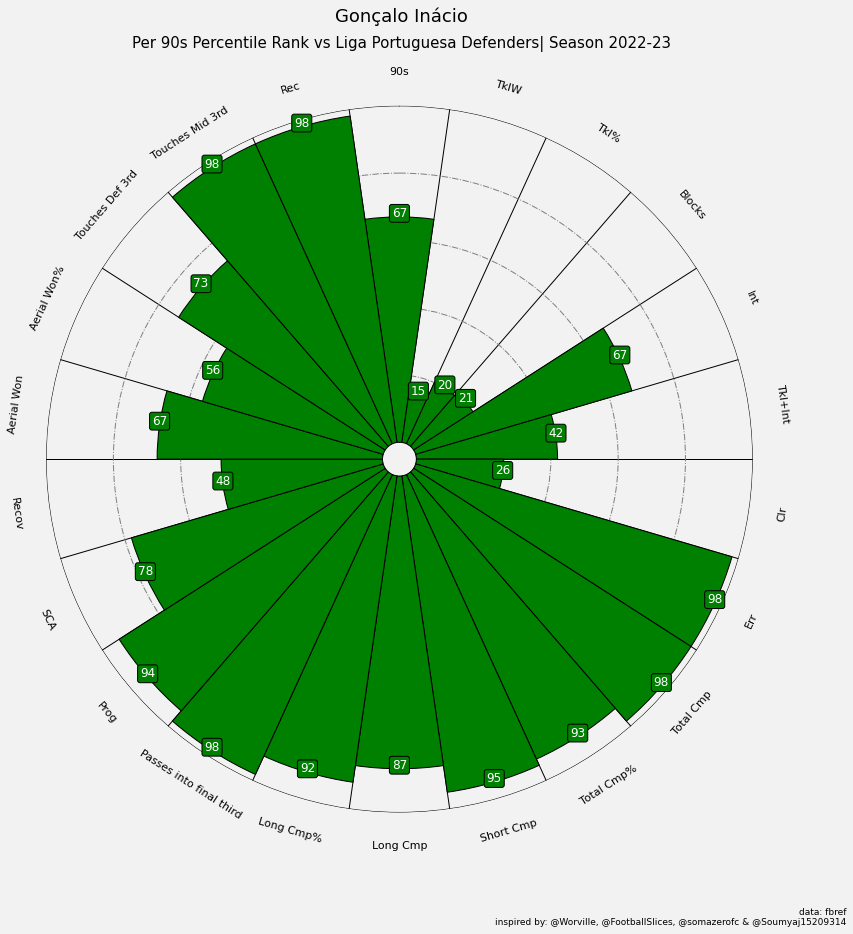

In [35]:
pizza_plot(values_1,params,z='Gonçalo Inácio',c="green")

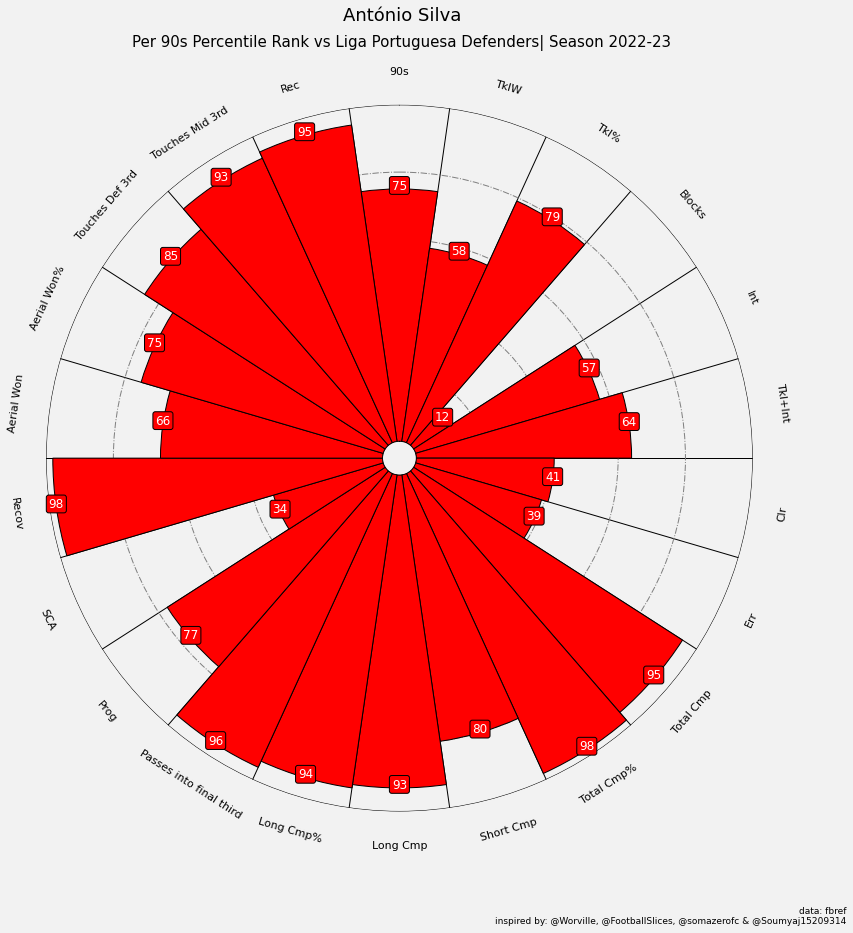

In [36]:
pizza_plot(values_2,params,z="António Silva",c="red")

# Radar Charts 

In [37]:
df_radar = df_df[(df_df['Player']=='Gonçalo Inácio')|(df_df['Player']=='António Silva')]

In [38]:
df_radar = df_radar.reset_index()

In [39]:
df_radar=df_radar.drop(['index'],axis=1)

In [40]:
#Params
#Already defined above
params

['90s',
 'TklW',
 'Tkl%',
 'Blocks',
 'Int',
 'Tkl+Int',
 'Clr',
 'Err',
 'Total Cmp',
 'Total Cmp%',
 'Short Cmp',
 'Long Cmp',
 'Long Cmp%',
 'Passes into final third',
 'Prog',
 'SCA',
 'Recov',
 'Aerial Won',
 'Aerial Won%',
 'Touches Def 3rd',
 'Touches Mid 3rd',
 'Rec']

In [41]:
#add ranges to list of tuple pairs
ranges=[]
a_values = []
b_values = []
player_a ='Gonçalo Inácio'
player_b ='António Silva'

for x in params:
    a = min(df[params][x])
    a = a - (a*.25)
    
    b = max(df[params][x])
    b = b +(b*.25)
    
    ranges.append((a,b))

for x in range(len(df_radar['Player'])):
    if  df_radar['Player'][x] == player_a:
        a_values = df_radar.iloc[x].values.tolist()
    if  df_radar['Player'][x] == player_b:
        b_values = df_radar.iloc[x].values.tolist()
        
a_values = a_values[1:]
b_values = b_values[1:]

values_radar = [a_values,b_values]

In [42]:
#Radar plot title

title = dict(
    title_name = f'{player_a}',
    title_color = 'green',
    subtitle_name = 'Sporting',
    subtitle_color = 'green',
    title_name_2 = f'{player_b}',
    title_color_2 = 'red',
    subtitle_name_2 = 'Benfica',
    subtitle_color_2 = 'red',
    title_fontsize= 18,
    subtitle_fontsize = 11
)

endnote = 'Gonçalo Rosado \ndata via FBREF'

findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.


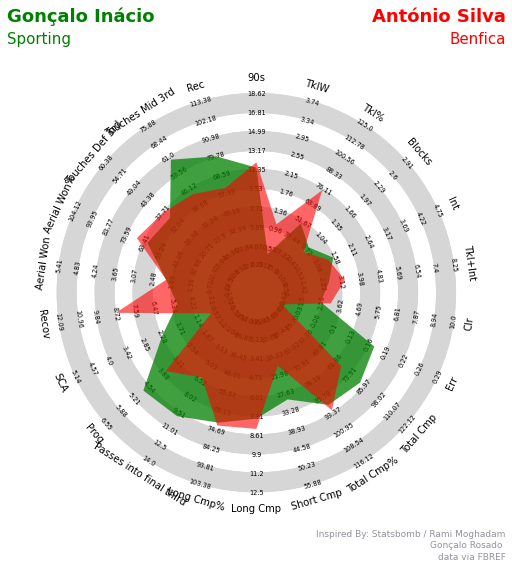

In [43]:
#radar
radar = Radar()

fig,ax = radar.plot_radar(ranges= ranges, params=params, values=values_radar, radar_color=['green','red'],alphas=[.75,.6],title=title,endnote=endnote,compare=True)

# Clustering

In [44]:
df_clus = df_df.drop(['Player','90s'],axis=1)

In [45]:
#scale
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(df_clus)

# Transform the data
df_standardized = scaler.transform(df_clus)

In [46]:
#PCA
from sklearn.decomposition import PCA

Text(0, 0.5, 'Explained variance ratio')

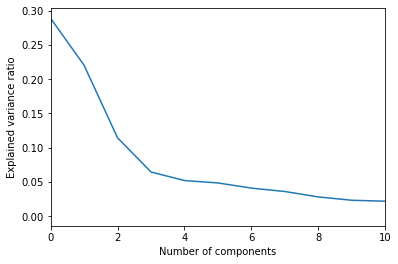

In [47]:
# Apply PCA to the data and compute the explained variance ratio
pca = PCA()
pca.fit(df_standardized)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.plot(explained_variance_ratio)
plt.xlim(0, 10)
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")

In [48]:
#explained variance
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative sum of explained variance ratio
cumulative_sum = np.cumsum(explained_variance_ratio)

# Select the number of components that explain at least 95% of the variance
n_components = np.where(cumulative_sum > 0.80)[0][0] + 1
print(f"Number of components that explain 70% of the variance: {n_components}")

Number of components that explain 70% of the variance: 7


In [49]:
pca = PCA(n_components=3,random_state=45)
pca.fit(df_standardized)
# Get the PCs
pcs = pca.transform(df_standardized)

[Text(0, 0.5, 'Chance Creation'),
 Text(0, 1.5, 'Ball Playing'),
 Text(0, 2.5, 'No-Nonsense')]

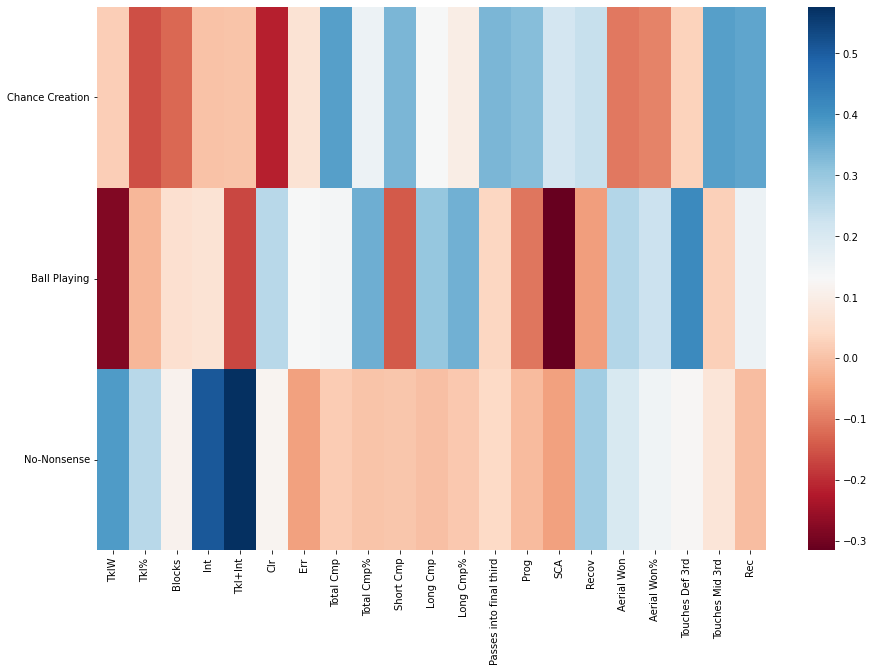

In [50]:
#create a heatmap
# Get the loadings
loadings = pca.components_

# Create a DataFrame of the loadings
loadings_df = pd.DataFrame(loadings, columns=df_clus.columns)
# Rename the rows
loadings_df.rename(index={0: 'Chance Creation',
                      1: 'Ball Playing',
                      2:'No-Nonsense'}, inplace=True)
plt.figure(figsize=(15, 10))
ax = sns.heatmap(loadings_df, cmap='RdBu')
# Rotate the y-axis labels by 90 degrees
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")


In [51]:
# Create a DataFrame of the PCs
pcs_df = pd.DataFrame(pcs, columns=['Chance Creation', 'Ball Playing','No-Nonsense'])
pcs_df

Chance Creation  Ball Playing  No-Nonsense
0          0.924394     -0.557402     1.163845
1         -1.043015      2.966560    -0.992864
2          1.364886     -2.072383    -2.185904
3         -0.876265      0.988782     0.771896
4         -2.022749      0.484596     0.874872
..              ...           ...          ...
84        -1.287911      3.773021    -1.834583
85        -2.142311      2.031704    -0.472371
86         0.496528     -1.904600    -0.175078
87        -3.581912      1.275095    -0.072631
88         0.357107     -0.508193     1.495986

[89 rows x 3 columns]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fd8e31af0>
Traceback (most recent call last):
  File "/home/big/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/big/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/big/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/big/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4fd8e31af0>
Traceback (most recent call last):
  File "/home/big/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/big/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/big/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/big/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


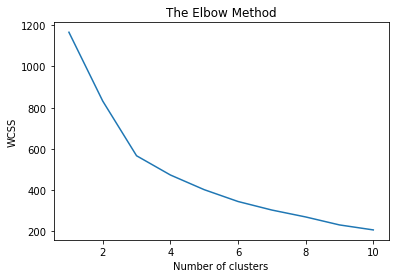

In [52]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(pcs_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
# 4 clusters

In [53]:
from sklearn.metrics import silhouette_score

# Create an empty list to store the silhouette scores
silhouette_scores = []

# Iterate over different number of clusters
for n_clusters in range(2, 11):
    # Create an instance of KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pcs_df)
    # Get the labels of the clusters
    labels = kmeans.labels_
    # Calculate the silhouette score for the current number of clusters
    silhouette_score_ = silhouette_score(pcs_df, labels)
    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_score_)

# Find the number of clusters that results in the highest silhouette score
best_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print("The optimal number of clusters is:", best_n_clusters)

The optimal number of clusters is: 3


In [54]:
#Kmenas clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(pcs_df)

# Get the cluster assignments for each data point
labels = kmeans.labels_


In [55]:
labels

array([0, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 2, 1, 0, 1, 2, 0, 0, 0, 1, 0,
       0, 2, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 1, 0, 1,
       0, 2, 0, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1, 1, 2, 1, 1, 2, 1, 2, 0, 0,
       0, 1, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 1, 1, 0, 1,
       0], dtype=int32)

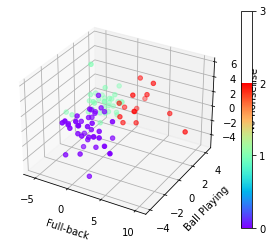

In [56]:
# Create a 3D scatter plot of the PCs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
c = ax.scatter(pcs_df.iloc[:, 0], pcs_df.iloc[:, 1], pcs_df.iloc[:, 2], c=labels, cmap='rainbow')
ax.set_xlabel("Full-back")
ax.set_ylabel("Ball Playing")
ax.set_zlabel("No-nonsense")
# Add a colorbar
cbar = plt.colorbar(c)
cbar.set_ticks(range(4))
cbar.set_ticklabels([0, 1, 2,3])

plt.show()


In [57]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Full-back'),yaxis = dict(title  = 'Ball Playing'),zaxis = dict(title  = 'No-nonsense'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = kmeans.labels_
trace = go.Scatter3d(x=pcs_df.iloc[:, 0], y=pcs_df.iloc[:, 1], z=pcs_df.iloc[:, 2], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10),coloraxis="coloraxis"))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [58]:
df_viz = df_df.copy()

In [59]:
df_viz['label'] = labels

In [60]:
df_viz[df_viz['Player'] == 'Gonçalo Inácio']

Player   90s  TklW  Tkl%  Blocks   Int  Tkl+Int   Clr   Err  \
51  Gonçalo Inácio  11.5  0.43  50.0    0.78  1.57     2.61  2.52  0.17   

    Total Cmp  ...  Passes into final third  Prog   SCA  Recov  Aerial Won  \
51       82.6  ...                     9.83  4.78  2.26   5.04        2.09   

    Aerial Won%  Touches Def 3rd  Touches Mid 3rd   Rec  label  
51         61.5             35.0             59.5  79.4      2  

[1 rows x 24 columns]

In [61]:
df_viz[df_viz['Player'] == 'Vasco Fernandes']

Player   90s  TklW  Tkl%  Blocks   Int  Tkl+Int   Clr   Err  \
45  Vasco Fernandes  13.9  0.58  54.5     1.8  1.22     2.01  3.81  0.14   

    Total Cmp  ...  Passes into final third  Prog   SCA  Recov  Aerial Won  \
45       38.3  ...                     1.51  0.86  0.43   4.82        1.15   

    Aerial Won%  Touches Def 3rd  Touches Mid 3rd   Rec  label  
45         69.6             28.7             23.5  31.9      1  

[1 rows x 24 columns]

In [62]:
#PHysical Cb
df_viz[df_viz['label'] == 1]

Player   90s  TklW   Tkl%  Blocks   Int  Tkl+Int   Clr   Err  \
1          Pedro Álvaro  10.9  0.37   71.4    1.38  1.10     1.74  4.40  0.00   
3           André Amaro  13.2  0.98   59.1    1.29  1.82     3.48  3.79  0.00   
4           Léo Andrade  11.8  0.68   78.6    1.69  2.20     3.39  3.05  0.08   
23      Kennedy Boateng  12.7  1.10   53.3    1.10  1.18     2.83  5.12  0.08   
24              Bolgado   3.5  0.86   75.0    2.00  0.86     2.86  8.00  0.00   
28          David Carmo   7.0  0.43   75.0    1.14  1.43     2.14  3.43  0.00   
30      Moises Castillo   5.0  2.00   90.9    1.20  3.80     6.60  3.40  0.00   
35        Matheus Costa   8.1  1.36   70.0    0.86  1.36     3.33  4.20  0.12   
42        Erick Ferigra   7.0  0.43   75.0    1.14  0.86     1.71  3.57  0.00   
43   Ivanildo Fernandes   5.7  0.35  100.0    1.05  0.88     1.93  6.49  0.00   
44      Rúben Fernandes  11.0  0.27   41.7    1.64  1.64     2.45  3.73  0.00   
45      Vasco Fernandes  13.9  0.58   54.5    1.80  1.22     2.01  3.81  0.14   
47        Paulo Godinho   5.2  0.96   71.4    0.58  1.15     2.50  5.00  0.00   
49    Cristian González  11.0  1.45   80.0    1.64  1.73     3.73  4.82  0.09   
53       Anderson Jesus  14.0  0.64   50.0    0.79  1.50     2.57  6.00  0.07   
56     Zainadine Júnior   8.1  0.49   50.0    0.86  1.48     2.47  3.33  0.12   
58            Nuno Lima   9.2  0.76   28.6    1.52  0.98     1.74  2.39  0.00   
63           Enea Mihaj  13.0  0.46   66.7    1.15  1.08     2.31  3.23  0.00   
64         Nélson Monte  13.0  0.46   41.7    1.00  1.77     2.31  5.69  0.00   
69       Miguel Nóbrega   5.2  0.96   62.5    1.92  0.58     1.92  3.85  0.00   
71       Paulo Oliveira   5.6  0.89  100.0    1.07  2.50     3.75  5.18  0.00   
72         Jerome Opoku  11.7  0.51   77.8    1.28  1.20     2.31  4.87  0.09   
74   João Othavio Basso  14.0  1.07   45.0    1.50  1.64     3.43  4.79  0.07   
75      Renato Pantalon   5.6  0.54   75.0    0.89  1.61     2.86  3.39  0.00   
77               Pedrão  12.0  0.67   64.3    1.33  1.50     2.92  3.83  0.00   
82         Flávio Ramos   8.3  0.24   62.5    1.81  1.57     2.65  4.94  0.00   
83        Filipe Relvas  14.9  0.54   71.4    1.07  2.01     3.09  5.23  0.00   
84             Riccieli  12.0  0.83   52.9    1.83  0.92     2.33  6.50  0.00   
87       Aderlan Santos  13.4  1.19   53.3    1.12  1.72     3.51  4.93  0.00   
90        Vincent Sasso  10.9  0.92   71.4    0.64  0.83     2.39  3.76  0.00   
98     Mikel Villanueva  11.5  0.35  100.0    0.96  1.83     2.52  3.91  0.09   
99       Bernardo Vital  11.0  0.45   77.8    0.64  0.45     1.45  6.00  0.09   
100      Steven Vitória  13.0  0.54   81.8    1.77  1.38     2.23  3.62  0.08   
102        Bruno Wilson  10.4  0.48   83.3    1.63  1.25     2.12  5.67  0.10   

     Total Cmp  ...  Passes into final third  Prog   SCA  Recov  Aerial Won  \
1         46.3  ...                     2.02  2.20  0.55   3.94        2.20   
3         38.0  ...                     2.88  2.27  0.76   4.92        2.20   
4         35.2  ...                     1.61  1.44  0.76   4.58        1.78   
23        32.5  ...                     1.65  1.50  0.39   4.49        3.70   
24        30.0  ...                     2.00  1.43  0.57   4.57        3.43   
28        49.0  ...                     3.86  2.57  0.29   4.00        2.00   
30        35.2  ...                     1.60  0.80  0.60   5.00        2.60   
35        36.2  ...                     1.60  1.48  1.11   5.80        2.84   
42        48.7  ...                     3.00  1.86  0.57   5.14        1.71   
43        18.2  ...                     1.23  0.88  0.00   2.63        2.46   
44        49.5  ...                     2.09  1.91  0.27   5.55        1.73   
45        38.3  ...                     1.51  0.86  0.43   4.82        1.15   
47        40.0  ...                     1.73  1.73  0.38   3.65        1.73   
49        30.8  ...                     1.00  0.82  0.18   5.64        1.36

In [63]:
#Ball Playing cb
df_viz[df_viz['label'] == 0]

Player   90s  TklW   Tkl%  Blocks   Int  \
0                     Rodrigo Abascal   7.5  1.33   52.9    1.20  1.87   
2                        Pedro Amaral  11.0  0.82   57.1    0.91  0.91   
5                    Vitorino Antunes  13.0  1.23   68.8    0.92  2.08   
22                      Alexander Bah   9.5  1.79   57.9    1.47  1.89   
25    Paulo Henrique Rodrigues Cabral   6.2  1.13   63.6    1.29  1.13   
26                      Reggie Cannon  10.1  1.29   57.9    1.19  2.38   
29                            Carraça   4.9  0.82   57.1    0.82  0.82   
32                  Rodrigo Conceição   3.7  2.43   75.0    1.08  1.08   
33   Alexandre Manuel Penetra Correia  10.5  1.24   42.9    1.24  1.81   
34          João Pedro Araújo Correia  14.0  0.64   46.2    1.29  1.07   
36                  Tomás Costa Silva   7.9  2.78   63.3    1.27  1.52   
37                        Sandro Cruz   3.5  2.00   71.4    1.43  1.71   
39                Hernán De La Fuente   6.0  2.17   62.5    1.67  1.50   
40                       Tiago Esgaio  12.0  0.92   64.3    1.25  0.83   
41                            Fabiano  10.7  2.99   71.4    1.50  1.59   
46                           Gilberto   5.5  1.09   50.0    1.45  1.27   
48                     Henrique Gomes   3.5  0.29   25.0    1.71  0.86   
50                      Álex Grimaldo  13.8  1.59   69.0    0.29  1.30   
52                       Carlos Isaac   3.9  1.79  100.0    0.77  1.28   
54                          Joãozinho  11.3  0.80   68.8    1.15  0.27   
55                        Igor Julião   3.6  1.39   75.0    0.83  1.11   
57                        Bruno Langa   9.4  1.38   50.0    1.38  1.28   
59                         Rúben Lima   9.5  0.95   42.9    1.37  2.11   
61                       Adrián Marín  10.3  1.07   69.2    0.68  1.07   
62                   João Mário Lopes   5.3  0.94   44.4    0.75  0.94   
66                         Fahd Moufi  13.3  0.68   61.5    1.43  2.03   
67             Christian Neiva Afonso  12.0  1.67   69.6    0.75  1.58   
70                         João Nunes   8.9  1.80   86.4    1.91  1.57   
79                       Victor Perea   4.0  0.25   25.0    1.25  0.00   
80                           Quaresma  11.8  1.02   55.0    0.68  0.68   
81                     Xavi Quintillà   5.0  1.60   62.5    0.60  0.00   
86                       Pierre Sagna  12.5  1.28   72.2    0.72  1.76   
88                       Tiago santos  10.2  1.67   72.4    0.69  0.78   
89                       Zaidu Sanusi   6.9  0.72   63.6    0.87  0.87   
91                     Moustapha Seck  13.4  1.57   81.8    1.19  1.34   
92                      Nuno Sequeira  12.9  1.47   61.8    0.85  1.24   
96                    Fernando Varela   6.9  1.16   81.8    1.16  1.30   
97                       Danilo veiga   7.6  1.84   84.6    0.66  1.84   
101                           Wendell   7.0  1.14   58.3    0.86  1.14   
103                    Nermin Zolotić   8.9  1.24   66.7    1.91  1.57   

     Tkl+Int   Clr   Err  Total Cmp  ...  Passes into final third  Prog   SCA  \
0       3.73  4.13  0.00       48.5  ...                     3.47  2.80  1.60   
2       2.45  1.64  0.00       45.8  ...                     3.82  3.64  2.00   
5       3.54  1.54  0.08       46.9  ...                     4.62  4.54  2.23   
22      4.63  1.16  0.11       60.4  ...                     5.16  4.74  3.05   
25      3.06  2.42  0.00       37.1  ...                     3.87  4.03  0.81   
26      4.06  3.17  0.00       44.0  ...                     1.68  1.19  0.10   
29      1.84  1.22  0.00       56.9  ...                     3.47  3.67  2.86   
32      4.32  2.43  0.00       48.4  ...                     1.35  1.62  2.97   
33      3.43  2.38  0.00       35.6  ...                     3.24  2.19  1.71   
34      2.21  3.00  0.00       39.3  ...                     2.21  2.71  2.93   
36      5.44  4.30  0.00       31.5  ...                     3.04  3.42  2.91   
37      3.71  3.43  0.00

In [64]:
#Full-bakcs
df_viz[df_viz['label'] == 2]

Player   90s  TklW  Tkl%  Blocks   Int  Tkl+Int   Clr   Err  \
6       Tomás Araújo   3.0  0.33  60.0    2.33  1.67     4.33  7.67  0.00   
27     Fábio Cardoso   7.9  0.25  66.7    0.13  1.14     1.65  3.04  0.00   
31  Sebastián Coates  11.5  0.43  70.0    1.04  0.61     1.65  2.61  0.00   
38       Lucas Cunha  13.0  0.38  62.5    1.15  1.23     1.69  4.31  0.00   
51    Gonçalo Inácio  11.5  0.43  50.0    0.78  1.57     2.61  2.52  0.17   
60      Iván Marcano   6.8  0.44  50.0    1.18  1.18     1.62  2.50  0.15   
65            Morato   4.0  1.25  50.0    0.50  1.25     2.50  2.50  0.00   
68     Sikou Niakaté  10.9  0.73  50.0    1.19  1.74     3.03  3.94  0.00   
73  Nicolás Otamendi  14.0  1.57  63.6    0.86  2.43     4.50  2.93  0.00   
76           Patrick   6.0  1.17  41.7    1.00  1.33     3.00  2.83  0.00   
78              Pepe   6.0  2.00  56.3    0.50  1.33     4.00  3.50  0.00   
85          Josué Sá   6.5  1.23  20.0    0.92  0.92     2.62  4.15  0.00   
93     António Silva  12.0  1.08  75.0    0.67  1.42     3.33  3.08  0.00   
94   Jerry St. Juste   4.3  0.23  33.3    0.47  1.40     2.09  1.63  0.23   
95     Vítor Tormena  13.1  0.61  41.7    1.30  1.45     2.21  3.74  0.00   

    Total Cmp  ...  Passes into final third  Prog   SCA  Recov  Aerial Won  \
6        66.0  ...                     5.67  4.33  1.67   7.33        4.33   
27       62.2  ...                     2.28  2.66  0.76   4.18        2.28   
31       63.7  ...                     5.22  4.17  0.87   5.91        1.65   
38       54.8  ...                     5.69  5.23  1.08   4.85        1.46   
51       82.6  ...                     9.83  4.78  2.26   5.04        2.09   
60       59.4  ...                     2.79  2.65  0.59   5.74        2.79   
65       59.3  ...                     5.50  3.50  0.75   7.75        2.00   
68       55.8  ...                     2.94  3.03  0.83   5.87        2.29   
73       74.0  ...                     4.71  4.14  1.07   7.64        2.57   
76       52.5  ...                     3.83  4.00  1.00   5.00        1.33   
78       55.5  ...                     5.50  5.00  1.50   9.67        2.83   
85       49.7  ...                     6.31  4.00  1.38   4.62        1.08   
93       66.8  ...                     6.25  3.75  0.67   8.67        2.08   
94       97.7  ...                    11.20  5.12  3.95   7.67        0.93   
95       51.0  ...                     5.34  2.67  1.30   5.34        2.14   

    Aerial Won%  Touches Def 3rd  Touches Mid 3rd   Rec  label  
6          61.9             48.3             44.3  57.0      2  
27         72.0             37.1             34.2  58.6      2  
31         63.3             26.4             50.2  60.1      2  
38         65.5             35.5             35.8  49.8      2  
51         61.5             35.0             59.5  79.4      2  
60         79.2             37.8             33.5  53.1      2  
65         66.7             33.3             40.0  50.8      2  
68         69.4             39.0             35.7  51.7      2  
73         66.7             36.4             51.7  65.9      2  
76         61.5             30.5             38.8  47.8      2  
78         73.9             40.5             35.0  48.7      2  
85         63.6             28.3             33.5  46.2      2  
93         67.6             37.5             43.7  60.3      2  
94         40.0             38.1             60.7  90.7      2  
95         71.8             34.6             33.7  48.2      2  

[15 rows x 24 columns]

In [65]:
#Describe based on cluster label
df_viz.groupby("label").mean()

90s      TklW       Tkl%    Blocks       Int   Tkl+Int       Clr  \
label                                                                           
0       8.697500  1.349500  62.745000  1.111000  1.284500  3.350750  2.550250   
1      10.082353  0.729706  67.997059  1.273235  1.442059  2.693529  4.527059   
2       8.700000  0.808667  52.720000  0.934667  1.378000  2.722000  3.396667   

            Err  Total Cmp  Total Cmp%  ...  Long Cmp%  \
label                                   ...              
0      0.006500  41.340000   74.820000  ...  45.915000   
1      0.035882  39.044118   83.050000  ...  60.723529   
2      0.036667  63.400000   87.993333  ...  67.366667   

       Passes into final third      Prog       SCA     Recov  Aerial Won  \
label                                                                      
0                     3.037000  3.105500  2.072000  5.463500    1.325750   
1                     1.929706  1.637059  0.518824  4.412353    2.156176   
2                     5.537333  3.935333  1.312000  6.352000    2.123333   

       Aerial Won%  Touches Def 3rd  Touches Mid 3rd        Rec  
label                                                            
0        52.240000        21.420000        28.767500  36.440000  
1        62.347059        33.523529        22.335294  35.573529  
2        65.640000        35.886667        42.020000  57.886667  

[3 rows x 22 columns]

In [66]:
# Radar Plot with PCA
df_dim= pcs_df.copy()
df_dim['Label'] = labels
x=df_viz['Player'].reset_index()
x= x.drop(['index'],axis=1)
df_dim['Player'] = x

In [67]:
df_dim[df_dim['Player'] == 'Gonçalo Inácio']

Chance Creation  Ball Playing  No-Nonsense  Label          Player
36         7.173893      2.724902    -0.343827      2  Gonçalo Inácio

In [68]:
df_dim[df_dim['Player'] == 'António Silva']

Chance Creation  Ball Playing  No-Nonsense  Label         Player
78         3.971738      2.467894     1.650758      2  António Silva

In [69]:
#Params
params_pca = list(df_dim.columns)
params_pca = params_pca[:-2]
print(params_pca)

['Chance Creation', 'Ball Playing', 'No-Nonsense']


In [70]:
player_1 = df_dim.loc[df_dim['Player']=='Gonçalo Inácio'].reset_index()
player_1 = list(player_1.loc[0])
player_1 = player_1[1:-2]
player_1

[7.173893058043263, 2.72490217979255, -0.34382679184789555]

In [71]:
print(len(params_pca),len(player_1))

3 3


In [72]:
player_2 = df_dim.loc[df_dim['Player']=='António Silva'].reset_index()
player_2 = list(player_2.loc[0])
player_2 = player_2[1:-2]
player_2

[3.9717381317396376, 2.4678944129099096, 1.6507575819798967]

In [73]:
player_2

[3.9717381317396376, 2.4678944129099096, 1.6507575819798967]

In [74]:
#calculate percentile
values_1 = []
for x in range(len(params_pca)):
        values_1.append(math.floor(stats.percentileofscore(df_dim[params_pca[x]],player_1[x])))
        


In [75]:
values_2 = []
for x in range(len(params_pca)):
        values_2.append(math.floor(stats.percentileofscore(df_dim[params_pca[x]],player_2[x])))

In [76]:
values_1

[98, 93, 44]

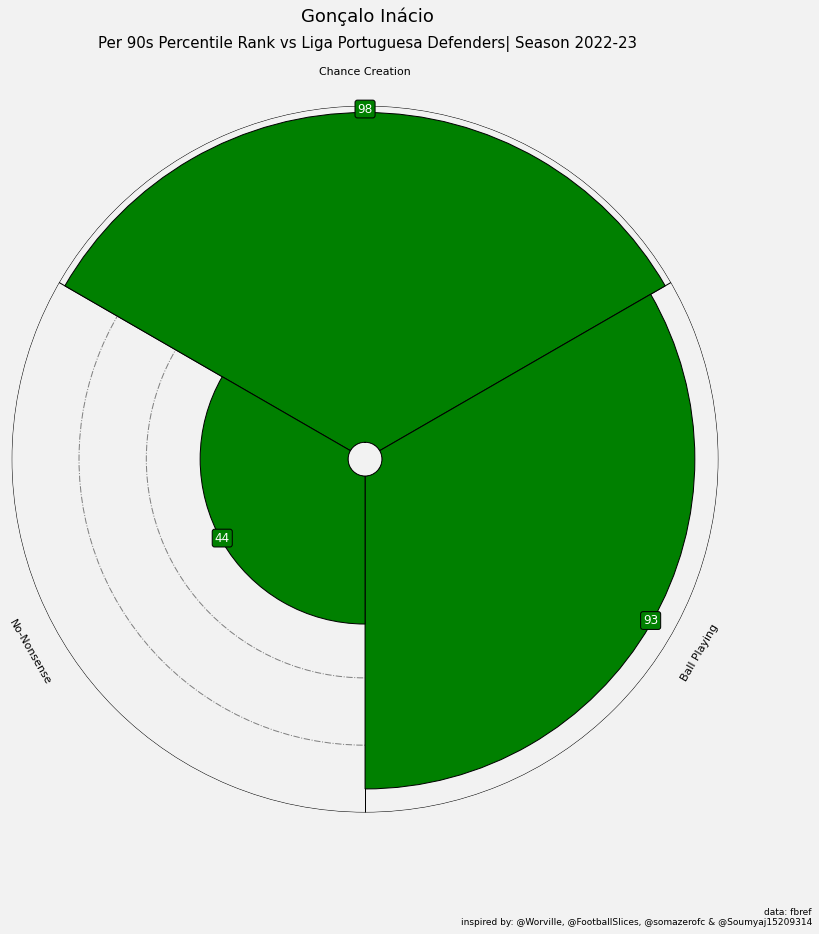

In [77]:
#Individual pizza plot
pizza_plot(values_1,params_pca,z='Gonçalo Inácio',c="green")

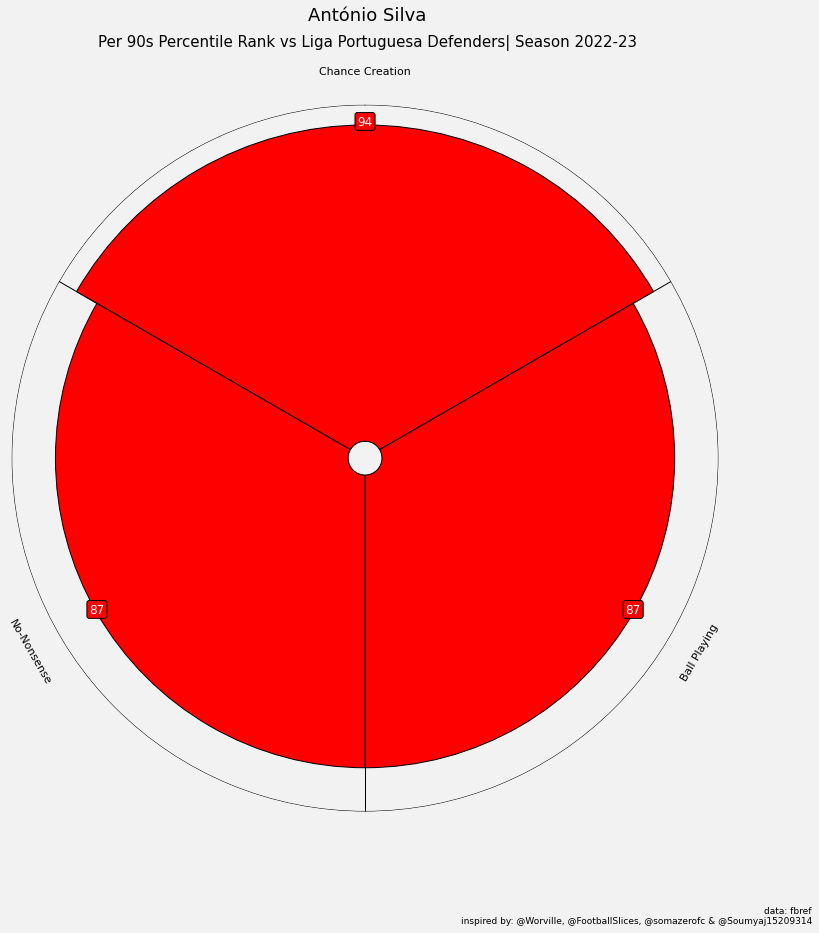

In [78]:
pizza_plot(values_2,params_pca,z='António Silva',c="red")

In [79]:
df_radar_2 = df_dim[(df_dim['Player']=='Gonçalo Inácio')|(df_dim['Player']=='António Silva')]

In [80]:
df_radar_2 = df_radar_2.reset_index()

In [81]:
df_radar_2=df_radar_2.drop(['index','Label'],axis=1)

In [82]:
df_radar_2

Chance Creation  Ball Playing  No-Nonsense          Player
0         7.173893      2.724902    -0.343827  Gonçalo Inácio
1         3.971738      2.467894     1.650758   António Silva

In [83]:
#Params
#Already defined above
params_pca

['Chance Creation', 'Ball Playing', 'No-Nonsense']

In [84]:
#add ranges to list of tuple pairs
ranges=[]
a_values = []
b_values = []
player_a ='Gonçalo Inácio'
player_b ='António Silva'

for x in params_pca:
    a = 0
    
    b = 100
    
    ranges.append((a,b))
        
a_values = values_1
b_values = values_2

values_radar = [a_values,b_values]

In [85]:
#Radar plot title

title = dict(
    title_name = f'{player_a}',
    title_color = 'green',
    subtitle_name = 'Sporting',
    subtitle_color = 'green',
    title_name_2 = f'{player_b}',
    title_color_2 = 'red',
    subtitle_name_2 = 'Benfica',
    subtitle_color_2 = 'red',
    title_fontsize= 18,
    subtitle_fontsize = 11
)

endnote = 'Gonçalo Rosado \ndata via FBREF'

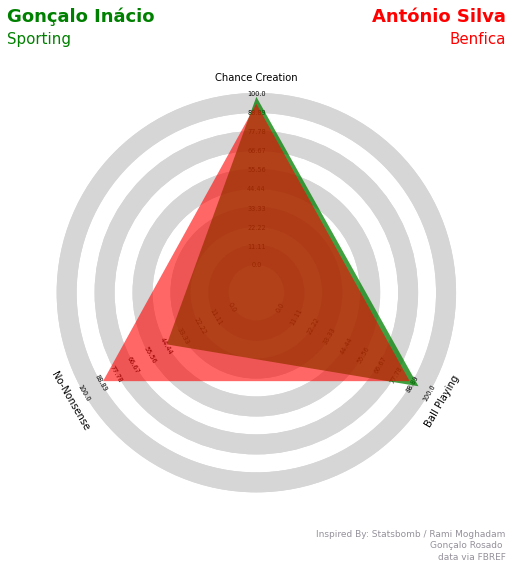

In [86]:
#radar
radar = Radar()

fig,ax = radar.plot_radar(ranges= ranges, params=params_pca, values=values_radar, radar_color=['green','red'],alphas=[.75,.6],title=title,endnote=endnote,compare=True)

In [87]:
#Create fuction 
#Create radar chart for comparision
def radar_plot(p1,p2,c1,c2,cl1,cl2):
    #Players data
    player_1 = df_dim.loc[df_dim['Player']==p1].reset_index()
    player_1 = list(player_1.loc[0])
    player_1 = player_1[1:-2]
    player_2 = df_dim.loc[df_dim['Player']==p2].reset_index()
    player_2 = list(player_2.loc[0])
    player_2 = player_2[1:-2]
    values_1 = []
    for x in range(len(params_pca)):
        values_1.append(math.floor(stats.percentileofscore(df_dim[params_pca[x]],player_1[x])))
    values_2 = []
    for x in range(len(params_pca)):
        values_2.append(math.floor(stats.percentileofscore(df_dim[params_pca[x]],player_2[x])))
    #add ranges to list of tuple pairs
    ranges=[]
    a_values = []
    b_values = []
    player_a = p1
    player_b = p2

    for x in params_pca:
        a = 0
    
        b = 100
    
        ranges.append((a,b))
        
    a_values = values_1
    b_values = values_2

    values_radar = [a_values,b_values]
    #Radar plot title

    title = dict(
        title_name = f'{player_a}',
        title_color = c1,
        subtitle_name = cl1,
        subtitle_color = c1,
        title_name_2 = f'{player_b}',
        title_color_2 = c2,
        subtitle_name_2 = cl2,
        subtitle_color_2 = c2,
        title_fontsize= 18,
        subtitle_fontsize = 11
    )

    endnote = 'Gonçalo Rosado \ndata via FBREF'
    #radar
    radar = Radar()

    fig,ax = radar.plot_radar(ranges= ranges, params=params_pca, values=values_radar, radar_color=[c1,c2],alphas=[.75,.6],title=title,endnote=endnote,compare=True)

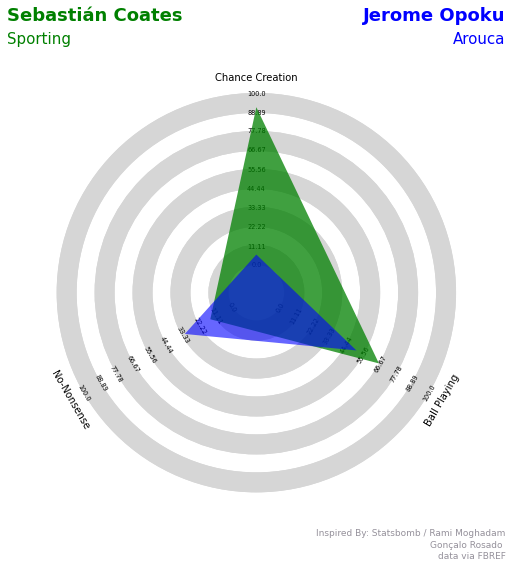

In [88]:
radar_plot(p1='Sebastián Coates',p2='Jerome Opoku',c1='green',c2='blue',cl1='Sporting',cl2='Arouca')

In [89]:
from sklearn.metrics import pairwise_distances

# get the cluster assignments for each sample
cluster_assignments = kmeans.labels_

# get the cluster centroids
centroids = kmeans.cluster_centers_

# calculate the distance from each sample to each centroid
distances = pairwise_distances(pcs_df, centroids)

# print the distances for the first sample
print(distances[57])

[4.19424327 1.71838633 6.54983737]
